In [1]:
import platform
print(f"platform.python_version(): {platform.python_version()}")

import os
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')

import requests

# 檢查CUDA是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

platform.python_version(): 3.9.13
Using device: cuda


In [2]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
#######################################################################
#載入mfcc為data
npy_file_list = glob(f"..\\data\\mfccEduVer\\*.npy")
print(f"type(npy_file_list): {type(npy_file_list)}")
print(f"len(npy_file_list): {len(npy_file_list)}")

mfcc_list = []

for npy_file in tqdm(npy_file_list):
    mfcc = np.load(file=npy_file)
    mfcc_list.append(mfcc)

mfcc_list = np.array(mfcc_list)
print(f"type(mfcc_list): {type(mfcc_list)}")
print(f"mfcc_list.shape: {mfcc_list.shape}")

all_mfcc = []
for mfcc in mfcc_list:
    all_mfcc.append(mfcc)

data = np.array(all_mfcc)
data_len = len(data)
#######################################################################

#######################################################################
#載入labelByself為labels
load_data = np.load(f".\\labelByself.npz")
labels = load_data['data']
#######################################################################

every_epoch = [] 
every_d_loss = []
every_g_loss = []
every_DZ = []

class PhonemeDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class ConditionalGenerator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_shape, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.output_shape = output_shape
        self.output_dim = output_shape[0] * output_shape[1]
        self.label_embedding = nn.Embedding(num_classes, input_dim)  # 將類別標籤轉換為與 z 相同維度的向量
        self.model = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 4), 
            nn.BatchNorm1d(hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 4, self.output_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_embedding(labels)
        input_data = torch.cat([z, label_embedding], dim=1)  # 將噪聲 z 與條件 labels 拼接
        x = self.model(input_data)
        return x.view(x.size(0), *self.output_shape)


class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_shape, hidden_dim, num_classes):
        super(ConditionalDiscriminator, self).__init__()
        self.input_dim = input_shape[0] * input_shape[1]
        self.label_embedding = nn.Embedding(num_classes, self.input_dim)  # 將類別標籤轉換為與輸入數據相同維度的向量
        self.model = nn.Sequential(
            nn.Linear(self.input_dim * 2, hidden_dim * 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 8, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        label_embedding = self.label_embedding(labels)
        input_data = torch.cat([x.view(x.size(0), -1), label_embedding], dim=1)  # 將輸入數據與條件 labels 拼接
        return self.model(input_data)

def get_max_batch_size(model, input_shape):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    max_memory = torch.cuda.get_device_properties(0).total_memory  
    reserved_memory = torch.cuda.memory_reserved(0)  
    free_memory = max_memory - reserved_memory  

    # 計算每個樣本所需的記憶體（假設每個浮點數佔用4字節）
    sample_size = (input_shape[0] * input_shape[1] + model.label_embedding.embedding_dim) * 4 + sum(p.numel() for p in model.parameters()) * 4

    # 計算最大批量大小
    max_batch_size = free_memory // sample_size if sample_size > 0 else 1
    return max_batch_size

# 超參數
input_dim = 572  # 輸入數據的特徵數量13*44=572
hidden_dim = 128 # input_dim的一半286
generator_learning_rate = 0.00000001
discriminator_learning_rate = 0.00000001
num_epochs = 5000 # 訓練次數
d_steps = 1  # 每個生成器步驟後訓練判別器的步數
g_steps = 3  # 每個判別器步驟後訓練生成器的步數

# 假設原始MFCC矩陣的形狀為(13, 44)
mfcc_shape = (13, 44)
num_classes = 1467

# 初始化生成器和判別器
generator = ConditionalGenerator(input_dim, hidden_dim, mfcc_shape, num_classes).to(device)
discriminator = ConditionalDiscriminator(mfcc_shape, hidden_dim, num_classes).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr = generator_learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr= discriminator_learning_rate)

scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=500, gamma=0.5) # 每1000步將學習率減半
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=1000, gamma=0.5) # 每1000步將學習率減半

# 計算最大批量大小並創建數據集和數據加載器
max_batch_size = get_max_batch_size(discriminator, mfcc_shape)
print(f'Maximum batch size that can be used: {max_batch_size}')

# 創建數據集和數據加載器
dataset = PhonemeDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=max_batch_size, shuffle=True)

for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(dataloader):
        data = data.to(device)
        labels = labels.to(device)  # 標籤同樣移動到設備上
        batch_size = data.size(0)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 訓練判別器
        for _ in range(d_steps):
            outputs = discriminator(data, labels)  # 輸入數據和對應的標籤
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            z = torch.randn(batch_size, input_dim).to(device)
            fake_data = generator(z, labels)  # 使用相同的標籤生成數據
            outputs = discriminator(fake_data.detach(), labels)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            d_loss = d_loss_real + d_loss_fake
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # 訓練生成器
        for _ in range(g_steps):
            z = torch.randn(batch_size, input_dim).to(device)
            fake_data = generator(z, labels)  # 使用相同的標籤生成數據
            outputs = discriminator(fake_data, labels)
            g_loss = criterion(outputs, real_labels)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

    # 更新學習率調度器
    scheduler_G.step()
    scheduler_D.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
          f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    every_epoch.append(epoch)
    every_d_loss.append(d_loss.item())
    every_g_loss.append(g_loss.item())
    every_DZ.append(fake_score.mean().item())


print('訓練完成！')

type(npy_file_list): <class 'list'>
len(npy_file_list): 45168


100%|██████████| 45168/45168 [01:02<00:00, 722.31it/s]


type(mfcc_list): <class 'numpy.ndarray'>
mfcc_list.shape: (45168, 13, 44)
Maximum batch size that can be used: 2381
Epoch [1/5000], d_loss: 1.7624, g_loss: 0.6954, D(x): 0.39, D(G(z)): 0.50
Epoch [2/5000], d_loss: 1.7796, g_loss: 0.6951, D(x): 0.39, D(G(z)): 0.50
Epoch [3/5000], d_loss: 1.7818, g_loss: 0.6952, D(x): 0.39, D(G(z)): 0.50
Epoch [4/5000], d_loss: 1.7677, g_loss: 0.6957, D(x): 0.39, D(G(z)): 0.50
Epoch [5/5000], d_loss: 1.7549, g_loss: 0.6951, D(x): 0.39, D(G(z)): 0.50
Epoch [6/5000], d_loss: 1.7657, g_loss: 0.6957, D(x): 0.39, D(G(z)): 0.50
Epoch [7/5000], d_loss: 1.7545, g_loss: 0.6955, D(x): 0.39, D(G(z)): 0.50
Epoch [8/5000], d_loss: 1.7739, g_loss: 0.6950, D(x): 0.39, D(G(z)): 0.50
Epoch [9/5000], d_loss: 1.7581, g_loss: 0.6946, D(x): 0.39, D(G(z)): 0.50
Epoch [10/5000], d_loss: 1.7697, g_loss: 0.6949, D(x): 0.39, D(G(z)): 0.50
Epoch [11/5000], d_loss: 1.7540, g_loss: 0.6951, D(x): 0.39, D(G(z)): 0.50
Epoch [12/5000], d_loss: 1.7439, g_loss: 0.6945, D(x): 0.40, D(G(z))

In [3]:
# DISCORD -> 設定 -> 整合 -> Webhook -> 新 Webhook > -> 複製 Webhook 網址
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1287413088970346557/30gx7NdIfSxS1BRWk28IRkOHJeoET-ihIN_KAjYeXYkrpPeI0hBnE-68AHzhpTR4h3et"
requests.post(
    url=DISCORD_WEBHOOK_URL,
    data={"content": "cGan訓練已完成!"}
)

<Response [204]>

In [4]:
torch.save(generator.state_dict(), f".\\cGAN_generator_edu_model.pth")

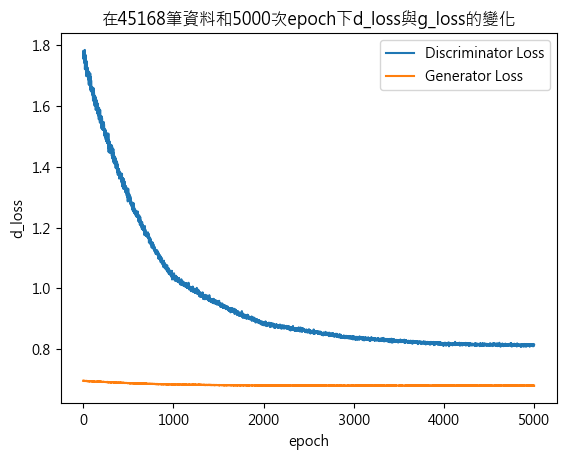

In [5]:
plt.plot(every_epoch,  every_d_loss, linestyle='-', label='Discriminator Loss')
plt.plot(every_epoch,  every_g_loss, linestyle='-', label='Generator Loss')
plt.title(f'在{data_len}筆資料和{num_epochs}次epoch下d_loss與g_loss的變化')
plt.xlabel('epoch')
plt.ylabel('d_loss')


plt.legend() 

plt.show()

In [7]:
class ConditionalGenerator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_shape, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.output_shape = output_shape
        self.output_dim = output_shape[0] * output_shape[1]
        self.label_embedding = nn.Embedding(num_classes, input_dim)  # 將類別標籤轉換為與 z 相同維度的向量
        self.model = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim * 4), 
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, self.output_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_embedding(labels)
        input_data = torch.cat([z, label_embedding], dim=1)  # 將噪聲 z 與條件 labels 拼接
        x = self.model(input_data)
        return x.view(x.size(0), *self.output_shape)
    
# 參數
input_dim =  13 * 44 
hidden_dim = 128
mfcc_shape = (13, 44)
num_classes = 1467

# 初始化生成器
generator = ConditionalGenerator(input_dim, hidden_dim, mfcc_shape, num_classes).to(device)
# 載入儲存的生成器權重
# generator.load_state_dict(torch.load(f".\\cGAN_generator_model.pth"))
generator.load_state_dict(torch.load(f".\\cGAN_generator_edu_model.pth", weights_only=True), strict=False)
# 確保模型設定為評估模式
generator.eval()

batch_size = 100
z = torch.randn(batch_size, input_dim).to(device)

labels = torch.tensor([10] * batch_size).to(device)  # 生成標籤為 10 的資料
fake_data = generator(z, labels)

print('確認單筆資料為',len(fake_data[0]),'x',len(fake_data[0][0]),'與預計輸出為 13x14')
print('一次生成',len(fake_data),'個 fake data')

確認單筆資料為 13 x 44 與預計輸出為 13x14
一次生成 100 個 fake data


In [8]:
fake_data[0]

tensor([[-4.2390e-01,  2.6198e-01,  6.7079e-01, -1.5125e-01,  1.9239e-01,
          1.8750e-01,  2.2031e-01,  2.2199e-02,  5.2301e-01,  3.4724e-01,
          4.6010e-01, -3.9118e-01, -2.1118e-01, -8.1402e-02,  1.0461e-01,
          5.1212e-02,  4.2786e-01, -2.4788e-01,  4.6548e-02,  3.3960e-01,
         -1.8760e-01,  2.5702e-01, -3.3250e-01, -5.7459e-01, -2.6983e-01,
          9.2081e-02,  2.1534e-01, -4.2436e-01,  5.2634e-01, -2.3875e-01,
          5.7696e-01, -2.0899e-01, -8.0385e-02,  1.3592e-02,  1.3780e-01,
          3.4173e-01, -1.3523e-01, -7.0242e-02,  8.5879e-03,  3.3801e-01,
          3.2166e-01,  1.9957e-01,  1.3010e-01,  1.6140e-01],
        [ 9.5577e-03, -3.5647e-01, -6.9239e-02, -2.2823e-01, -2.4665e-01,
          5.0312e-01, -2.0278e-03, -2.4282e-01,  4.0596e-01, -7.8143e-01,
          3.9804e-01, -1.1254e-01,  3.8259e-01,  2.1894e-01,  2.3257e-01,
          6.4662e-01, -3.7153e-01, -4.5744e-01,  2.8461e-01, -2.2236e-02,
          2.2886e-01, -1.6057e-01,  4.6615e-01,  1